In [1]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [26]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *
from copy import deepcopy

# Constructing a Quantum Layers

## One Qubit Quantum Circuit

Create object of the class by passing number of qubits, backend name, number of shots

run method of this class accepts angles for the parametarized gates and returns expectation value of Z operator

In [27]:
class QuantumCircuit:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """
    
    def __init__(self, backend, shots):
        # --- Circuit definition ---
        n_qubits = 1
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')
        
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)
        
        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        t_qc = transpile(self._circuit,
                         self.backend)
 
        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = [{self.theta: theta} for theta in thetas])
        job = self.backend.run(qobj)
        result = job.result().get_counts()
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys()))
        probabilities = counts / self.shots
        expectation = 0
        for s in range(len(states)):
            if states[s] == "0":
                expectation += probabilities[s]
            elif states[s] == "1":
                expectation -= probabilities[s]
        
        return np.array([expectation])

In [28]:
simulator = qiskit.Aer.get_backend('aer_simulator')

circuit = QuantumCircuit(simulator, 100)
print('Expected value for rotation pi {}'.format(circuit.run([np.pi])[0]))
circuit._circuit.draw()

Expected value for rotation pi 0.020000000000000018


┌───┐ ░ ┌───────────┐ ░ ┌─┐
     q: ┤ H ├─░─┤ Ry(theta) ├─░─┤M├
        └───┘ ░ └───────────┘ ░ └╥┘
meas: 1/═════════════════════════╩═
                                 0

## Two Qubit Quantum Circuit

Create object of the class by passing number of qubits, backend name, number of shots

run method of this class accepts angles for the parametarized gates and returns expectation value of Z^2 operator

In [6]:
class QuantumCircuit2:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """
    
    def __init__(self,backend, shots):
        # --- Circuit definition ---
        n_qubits = 2
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
        self.alpha = qiskit.circuit.Parameter('alpha')
        self.beta = qiskit.circuit.Parameter('beta')
      
        
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.alpha, 0)
        self._circuit.ry(self.beta, 1)
      
        
        
        self._circuit.measure_all()
        

        self.backend = backend
        self.shots = shots
    
    def run(self, angles):
        t_qc = transpile(self._circuit,
                         self.backend)

        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = [{self.alpha: angles[0], self.beta: angles[1],
                                           }])

        job = self.backend.run(qobj)
        result = job.result().get_counts()
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys()))
        probabilities = counts / self.shots
        expectation = 0
        for s in range(len(states)):
            if states[s] in ["00", "11"]:
                expectation += probabilities[s]
            elif states[s] in ["01", "10"]:
                expectation -= probabilities[s]
        return np.array([expectation])

In [7]:
simulator = qiskit.Aer.get_backend('aer_simulator')

circuit2 = QuantumCircuit2(simulator, 1000)
print('Expected value for rotation pi {}'.format(circuit2.run([np.pi, np.pi])[0]))
circuit2._circuit.draw()

Expected value for rotation pi -0.062000000000000055


┌───┐ ░ ┌───────────┐ ░ ┌─┐   
   q_0: ┤ H ├─░─┤ Ry(alpha) ├─░─┤M├───
        ├───┤ ░ └┬──────────┤ ░ └╥┘┌─┐
   q_1: ┤ H ├─░──┤ Ry(beta) ├─░──╫─┤M├
        └───┘ ░  └──────────┘ ░  ║ └╥┘
meas: 2/═════════════════════════╩══╩═
                                 0  1

## Defining a Quantum Layer

#### Forward pass : 
returns output returned by the run method of QuantumCircuit and QuantumCircuit2

#### Gradient Calculation :

#### Calculating gardient for quantum ciruits :
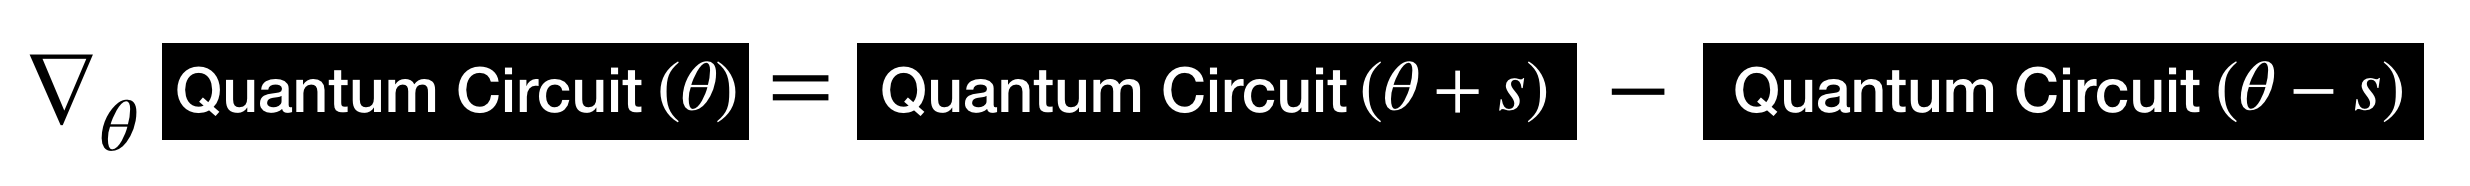

In [8]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit
        expectation_z = ctx.quantum_circuit.run(input[0].tolist())
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)
        
        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        
        all_shifts_right = []
        all_shifts_left = []
        for qubit in range(input_list.shape[1]):
            shift_right = deepcopy(input_list[0])
            shift_right[qubit] = shift_right[qubit] + ctx.shift
            all_shifts_right.append(shift_right)
            
            
            shift_left = deepcopy(input_list[0])
            shift_left[qubit] = shift_left[qubit] - ctx.shift
            all_shifts_left.append(shift_left)
        
       
            
        
        gradients = []
        for i in range(len(all_shifts_right)):
            expectation_right = ctx.quantum_circuit.run(all_shifts_right[i])
            expectation_left  = ctx.quantum_circuit.run(all_shifts_left[i])
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient[0][0])
    
            
      
        gradients = np.array(gradients).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(backend, shots)
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)
    
class Hybrid2(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, backend, shots, shift):
        super(Hybrid2, self).__init__()
        self.quantum_circuit = QuantumCircuit2(backend, shots)
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

In [9]:
# Concentrating on the first 100 samples
n_samples = 100

X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

# Leaving only labels 0 and 1 
idx = np.append(np.where(X_train.targets == 0)[0][:n_samples], 
                np.where(X_train.targets == 1)[0][:n_samples])

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)

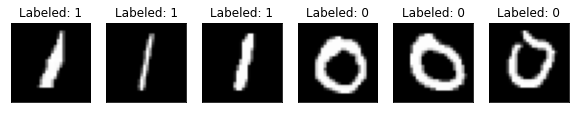

In [10]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
    n_samples_show -= 1

In [11]:
n_samples = 50

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_test.targets == 0)[0][:n_samples], 
                np.where(X_test.targets == 1)[0][:n_samples])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

## Convolutional Neural Networks

#### Convolutional neural networks are distinguished from other neural networks by their superior performance with image, speech, or audio signal inputs. They have three main types of layers, which are:

#### Convolutional layer

It requires a few components, which are input data and a filter.

Convolulational Operation :

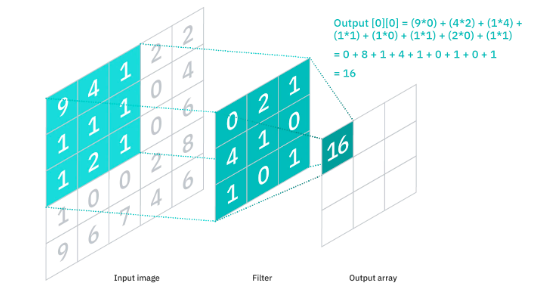

After each convolution operation, a CNN applies a Rectified Linear Unit (ReLU) transformation to the feature map, introducing nonlinearity to the model.

#### Pooling layer

Pooling layers, also known as downsampling, conducts dimensionality reduction, reducing the number of parameters in the input. 

#### Fully-connected (FC) layer

This layer performs the task of classification based on the features extracted through the previous layers and their different filters.

## Hybrid Quantum Neural Network

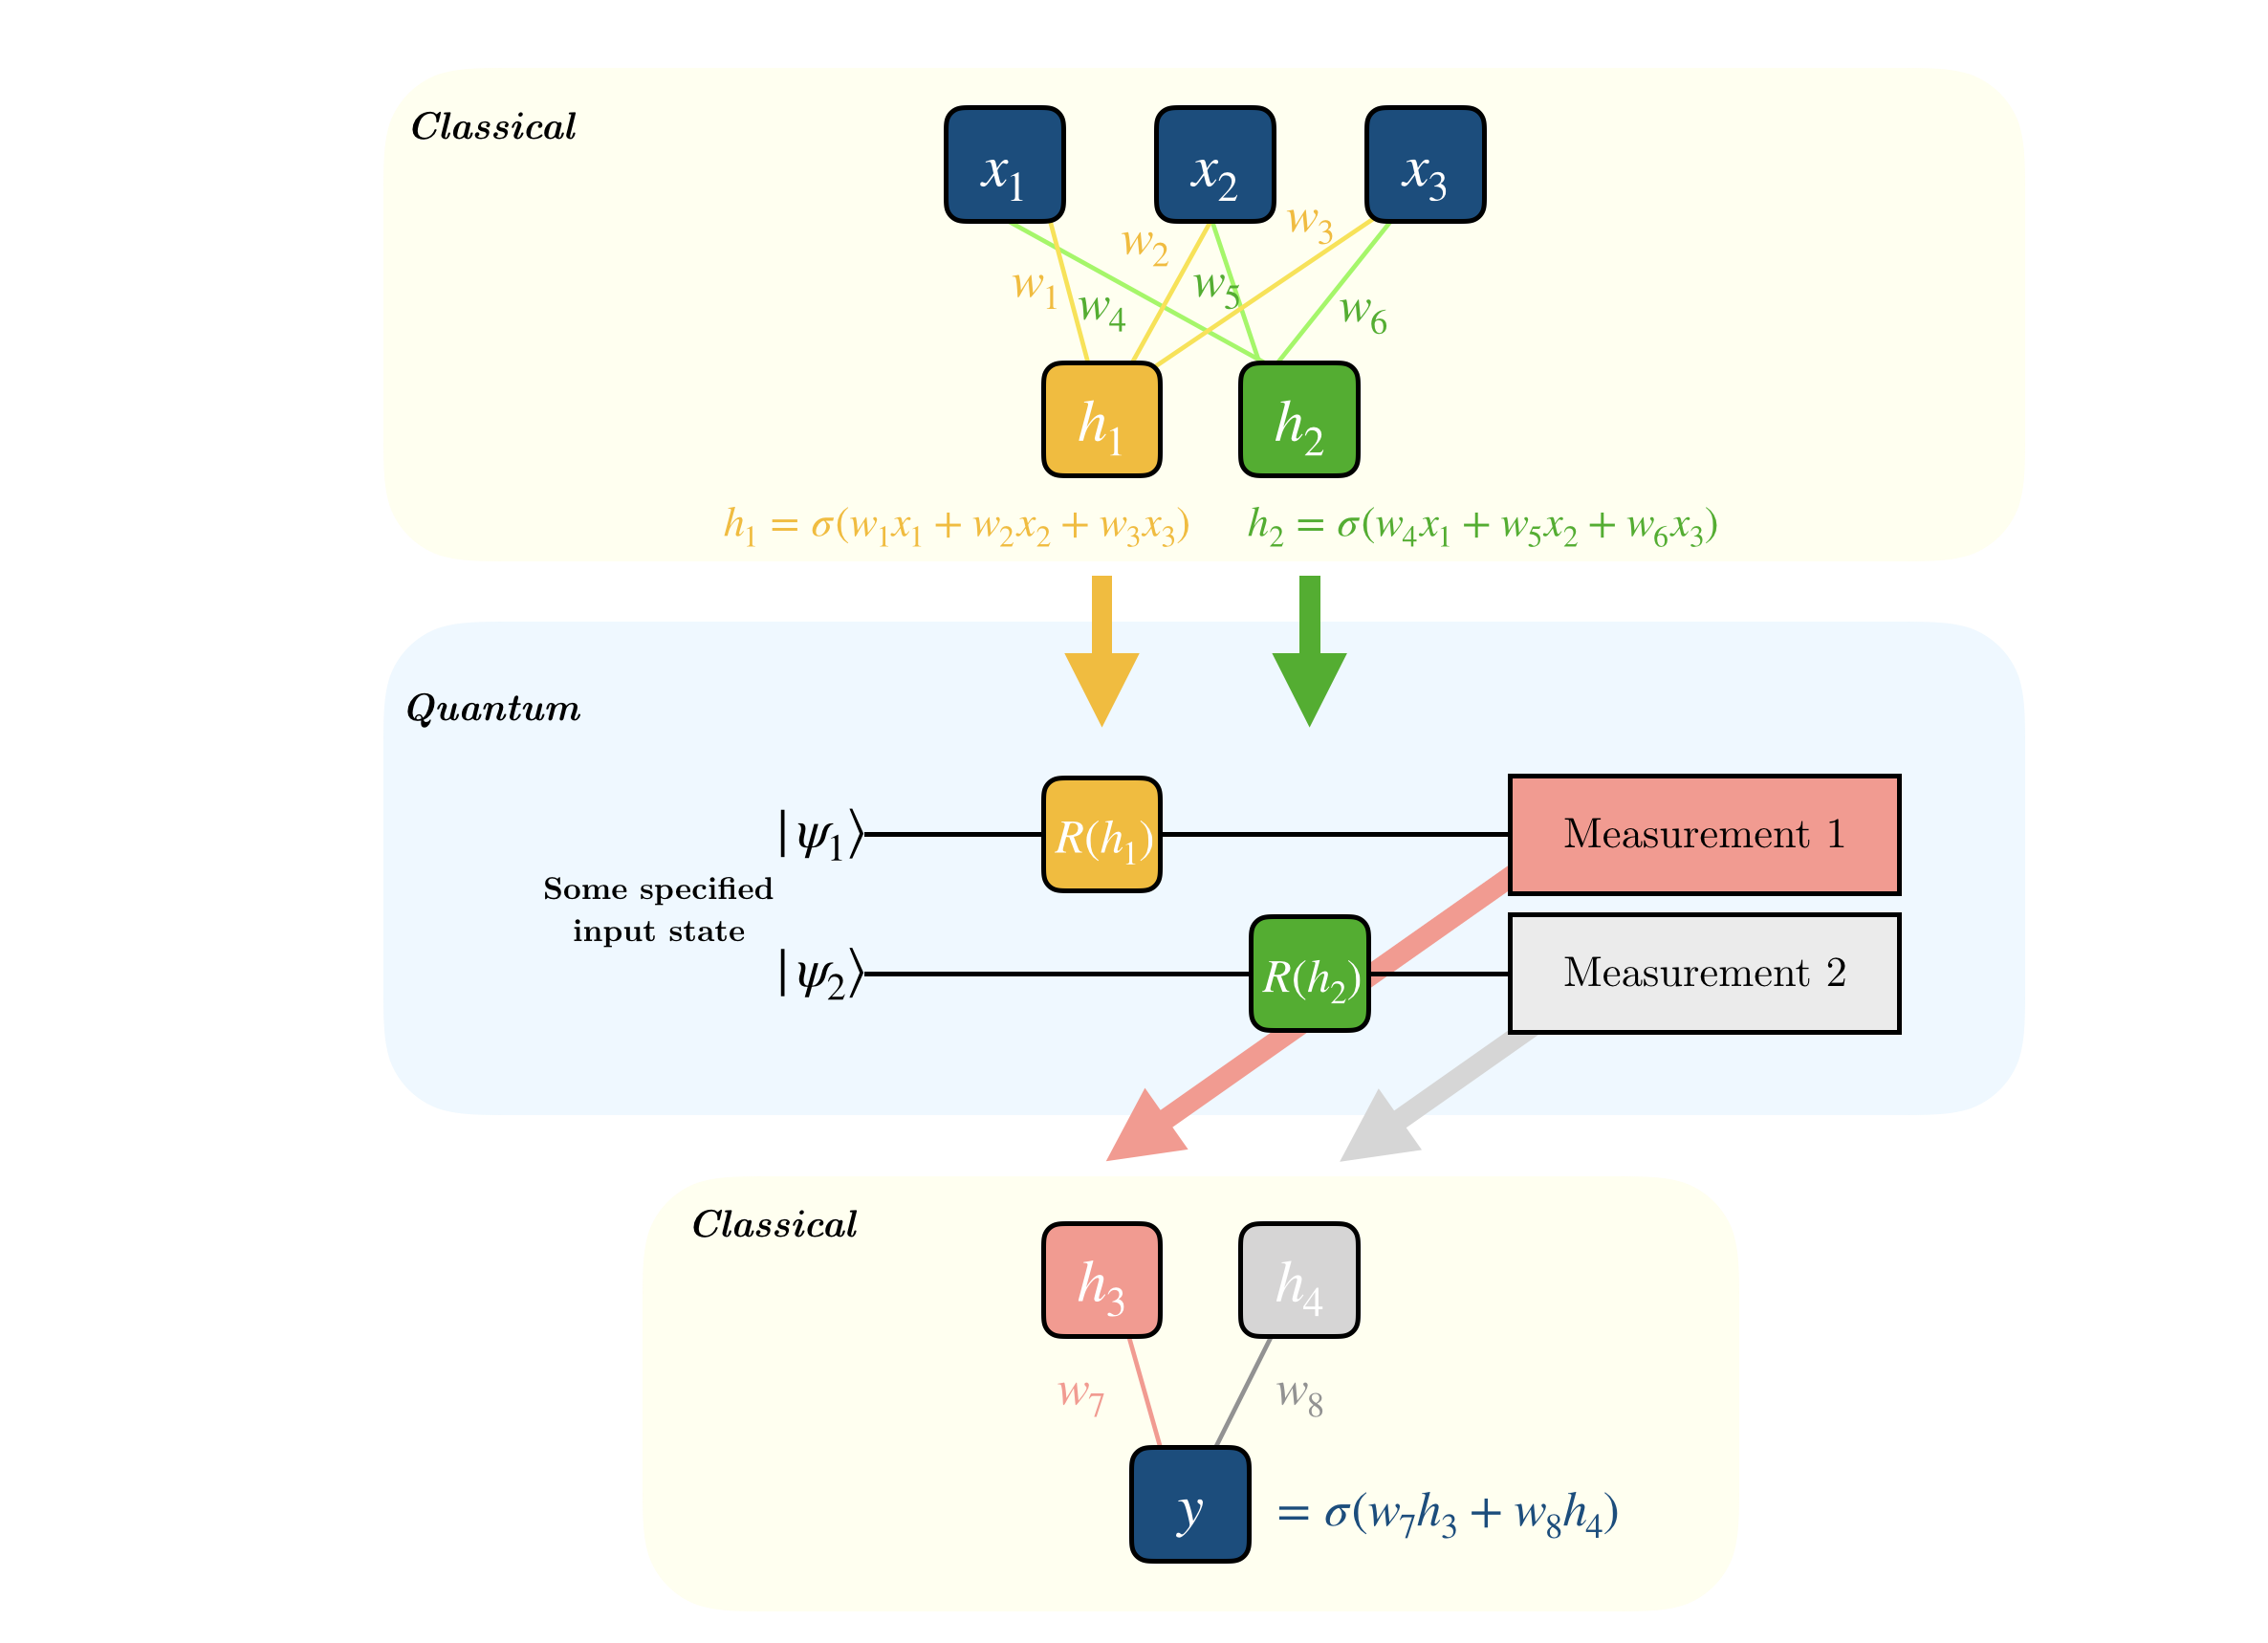

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5) 
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 2)
        self.hybrid2 = Hybrid2(qiskit.Aer.get_backend('aer_simulator'), 100, np.pi / 2)
        self.hybrid = Hybrid(qiskit.Aer.get_backend('aer_simulator'), 100, np.pi / 2)
        

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.hybrid2(x)
        x = self.hybrid(x)
        return torch.cat((x, 1 - x), -1)

In [13]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss() #nn.NLLLoss()

epochs = 30
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

/tmp/ipykernel_24034/3206065073.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  result = torch.tensor([expectation_z])


Training [3%]	Loss: 0.5178
Training [7%]	Loss: 0.3377
Training [10%]	Loss: 0.3068
Training [13%]	Loss: 0.2838
Training [17%]	Loss: 0.2762
Training [20%]	Loss: 0.2663
Training [23%]	Loss: 0.2590
Training [27%]	Loss: 0.2660
Training [30%]	Loss: 0.2554
Training [33%]	Loss: 0.2553
Training [37%]	Loss: 0.2507
Training [40%]	Loss: 0.2571
Training [43%]	Loss: 0.2530
Training [47%]	Loss: 0.2496
Training [50%]	Loss: 0.2457
Training [53%]	Loss: 0.2465
Training [57%]	Loss: 0.2475
Training [60%]	Loss: 0.2439
Training [63%]	Loss: 0.2468
Training [67%]	Loss: 0.2402
Training [70%]	Loss: 0.2479
Training [73%]	Loss: 0.2465
Training [77%]	Loss: 0.2423
Training [80%]	Loss: 0.2436
Training [83%]	Loss: 0.2454
Training [87%]	Loss: 0.2471
Training [90%]	Loss: 0.2464
Training [93%]	Loss: 0.2443
Training [97%]	Loss: 0.2445
Training [100%]	Loss: 0.2441


The negative log likelihood loss. It is useful to train a classification problem with C classes.
If provided, the optional argument weight should be a 1D Tensor assigning weight to each of the classes. This is particularly useful when you have an unbalanced training set.

Text(0, 0.5, 'Neg Log Likelihood Loss')

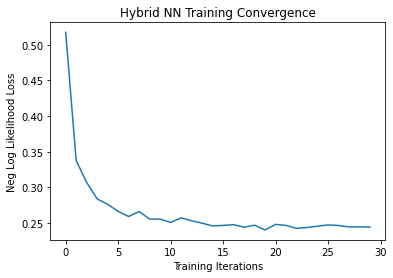

In [14]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [21]:
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on train data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(train_loader) * 100)
        )

Performance on train data:
	Loss: 0.2536
	Accuracy: 100.0%


In [22]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Performance on test data:
	Loss: 0.2539
	Accuracy: 100.0%


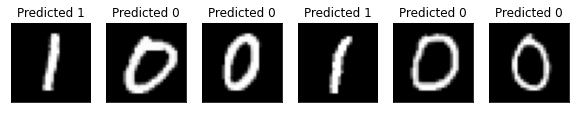

In [25]:
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model(data)
        
        #print(output)
        
        pred = output.argmax(dim=1, keepdim=True) 
        

        axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(pred.item()))
        
        count += 1